In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.6.0


# Set up the data

In [2]:
# Utility for loading up the dataset

def load_adult_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                    'martial_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names,
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'fnlwgt'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))

    y = y.to_frame()
    for col in X.columns:
      X[col] = X[col].astype('float32')

    for col in y.columns:
      y[col] = y[col].astype('float32')

    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    return X, y

class PandasDataSet(TensorDataset):
    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame('dummy')
        return torch.from_numpy(df.values).float()

In [3]:
# load adult data set
path = 'adult.data'
# path = 'adult.data'
X, y = load_adult_data(path)

n_features = X.shape[1]

# split into train/test set
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)
print(X_train.head())

features X: 30940 samples, 95 attributes
targets y: (30940, 1) samples
        age  education_num  capital_gain  capital_loss  hours_per_week  \
27719  17.0            7.0           0.0           0.0            12.0   
936    47.0           14.0           0.0           0.0            25.0   
3936   46.0           11.0           0.0           0.0            38.0   
8500   45.0           14.0           0.0        1902.0            50.0   
3882   51.0           10.0           0.0           0.0            40.0   

       workclass_Local-gov  workclass_Never-worked  workclass_Private  \
27719                  0.0                     0.0                1.0   
936                    0.0                     0.0                1.0   
3936                   0.0                     0.0                0.0   
8500                   0.0                     0.0                1.0   
3882                   0.0                     0.0                1.0   

       workclass_Self-emp-inc  workclass_Self

In [4]:
# Set up training & testing data
BATCH_SIZE = 100

train_data = PandasDataSet(X_train, y_train)
test_data = PandasDataSet(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print('# training samples:', len(train_data))
print('# testing samples:', len(test_data))
print('# batches:', len(train_loader))

print('# training samples:', len(test_data))
print('# batches:', len(test_loader))

# training samples: 24752
# testing samples: 6188
# batches: 247
# training samples: 6188
# batches: 61


# Define accuracy & Model

In [5]:
def accuracy(model, test_loader):
    correct = 0

    for examples, labels in test_loader:
        output = model.forward(examples)
        batch_correct = torch.sum(torch.abs(output - labels) < 0.5)
        correct += batch_correct

    acc = float(correct)/len(test_data)
    
    return acc

In [6]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

# The calculation for immediate sensitivity

In [11]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = criterion(outputs, labels)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    
    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p = 2)
    
    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    # (4) L2 norm of (3) - "immediate sensitivity"
    s = [torch.norm(v, p=2).numpy().item() for v in sensitivity_vec]
    
    '''
    if epoch > 5:
        print(f"inputs: ",inp)
        print(f"outputs: ", outputs)
        print(f"loss: ", loss)
        print(f"first_order_grads: ", first_order_grads)
        print(f"grad_l2_norm:: ", grad_l2_norm)
        print(f"sensitivity_vec: ", sensitivity_vec)
        print(f"sensitivies: ", s)
    '''

    loss.backward()
    return loss, s

# Train the model, calculating immediate sensitivities

In [12]:
def run_experiment(epsilon):
    # reset the model
    model = Classifier(n_features=n_features)
    model_criterion = nn.BCELoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 10
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 2
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for x_batch_train, y_batch_train in train_loader:
            model_optimizer.zero_grad()
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss)
            
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            all_sensitivities.append(batch_sensitivity)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)

            with torch.no_grad():
                for p in model.parameters():
                    p.grad += (sigma * torch.randn(1))

            model_optimizer.step()

        max_sensitivities.append(np.max(all_sensitivities))
        print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
        mean_sensitivities.append(np.mean(all_sensitivities))
        print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
        max_sigmas.append(np.max(sigmas))
        print("Max sigma for the epoch:", max_sigmas[-1])
        mean_sigmas.append(np.mean(sigmas))
        print("Mean sigma for the epoch:", mean_sigmas[-1])
        test_accs.append(accuracy(model, test_loader))
        print("Accuracy:", test_accs[-1])
    return accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs)

In [ ]:
epsilons = [0.1, 0.5, 1.0, 5.0, 10.0]
experiment_results = [run_experiment(epsilon)[0] for epsilon in epsilons]

Start of epoch 0
> <ipython-input-11-d09695c859f3>(3)grad_immediate_sensitivity()
      1 def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
      2     import pdb;pdb.set_trace()
----> 3     inp = Variable(inputs, requires_grad=True)
      4 
      5     outputs = model.forward(inp)

ipdb> n
> <ipython-input-11-d09695c859f3>(5)grad_immediate_sensitivity()
      3     inp = Variable(inputs, requires_grad=True)
      4 
----> 5     outputs = model.forward(inp)
      6     loss = criterion(outputs, labels)
      7 

ipdb> inp
tensor([[21., 12.,  0.,  ...,  0.,  0.,  0.],
        [33.,  4.,  0.,  ...,  0.,  0.,  0.],
        [65.,  9.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [33.,  9.,  0.,  ...,  0.,  0.,  0.],
        [32., 13.,  0.,  ...,  0.,  0.,  0.],
        [28., 10.,  0.,  ...,  0.,  0.,  0.]], requires_grad=True)
ipdb> inp.shape
torch.Size([100, 95])
ipdb> n
> <ipython-input-11-d09695c859f3>(6)grad_immediate_sensitivity()
      4 
      5     output

ipdb> len(first_order_grads)
8
ipdb> n
> <ipython-input-11-d09695c859f3>(15)grad_immediate_sensitivity()
     13 
     14     # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
---> 15     sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
     16 
     17     # (4) L2 norm of (3) - "immediate sensitivity"

ipdb> grad_l2_norm
tensor(6.0320, grad_fn=<NormBackward0>)
ipdb> grad_l2_norm.shape
torch.Size([])
ipdb> inp.shape
torch.Size([100, 95])
ipdb> inp.shape
torch.Size([100, 95])
ipdb> loss
tensor(4.8368, grad_fn=<BinaryCrossEntropyBackward>)
ipdb> outputs.shape
torch.Size([100, 1])
ipdb> loss
tensor(4.8368, grad_fn=<BinaryCrossEntropyBackward>)
ipdb> first_order_grads.shape
*** AttributeError: 'tuple' object has no attribute 'shape'
ipdb> first_order_grads
(tensor([[ 1.1807e-02, -8.3038e-04, -9.1315e-10,  ..., -1.1627e-04,
          0.0000e+00,  0.0000e+00],
        [ 5.9022e-02,  1.3360e-02,  0.0000e+00,  ...,  6.7357e-05,
          0.0000e

ipdb> grad_l2_norm.shape
torch.Size([])
ipdb> grad_l2_norm
tensor(6.0320, grad_fn=<NormBackward0>)
ipdb> first_order_grads
(tensor([[ 1.1807e-02, -8.3038e-04, -9.1315e-10,  ..., -1.1627e-04,
          0.0000e+00,  0.0000e+00],
        [ 5.9022e-02,  1.3360e-02,  0.0000e+00,  ...,  6.7357e-05,
          0.0000e+00,  0.0000e+00],
        [ 4.4895e-02,  1.7199e-02, -1.1803e-09,  ..., -1.3135e-15,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 9.0787e-02,  2.0865e-02, -2.5949e-09,  ..., -6.7996e-05,
          0.0000e+00,  0.0000e+00],
        [ 6.8043e-03,  9.5420e-03,  0.0000e+00,  ...,  1.8873e-04,
          0.0000e+00,  0.0000e+00],
        [-6.2801e-02, -8.2861e-03, -5.5224e-12,  ..., -2.5379e-15,
          0.0000e+00,  0.0000e+00]], grad_fn=<TBackward>), tensor([-1.2313e-03,  1.7313e-03,  1.2201e-03, -2.2022e-03, -2.3602e-04,
        -3.3513e-04,  6.0864e-06, -5.4566e-15,  0.0000e+00,  4.5198e-04,
         3.4942e-04,  0.0000e+00, -7.7745e-04, -3.1709e-03,  9.9410e-04,
   

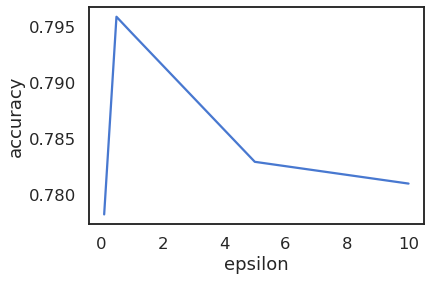

In [115]:
plt.plot(epsilons, experiment_results)
plt.xlabel('epsilon')
plt.ylabel('accuracy');

In [94]:
final_acc, info_tuple = run_experiment(0.1)

Start of epoch 0
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
t

torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1

torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1

torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 95])
torch.Size([100, 1])
torch.Size([100, 1])


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

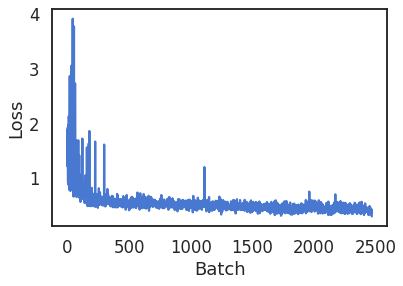

In [17]:
#the info tuple holds: (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs)
train_losses = info_tuple[0]

plt.plot(train_losses)
plt.xlabel("Batch")
plt.ylabel("Loss")

# MNIST

In [157]:
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F

In [158]:
# The labeled data from the dataloaders don't one-hot encode the labels... so I'm making a helper function to do it.
def one_hot_label(label,num_classes=10):
    zeros = [0.0]*num_classes
    zeros[label] = 1.0
    return torch.tensor(zeros)

In [193]:
def mnist_accuracy(model, test_loader):
    correct = 0
    num_data = 0

    #grab a batch from the test loader
    for examples, labels in test_loader:
        outputs = model.forward(examples)
        
        #for each output in the batch, check if the label is correct
        for i, output in enumerate(outputs):
            num_data += 1
            
            max_i = np.argmax(output.detach().numpy())
            if max_i == labels[i]:
                correct += 1

    acc = float(correct)/num_data
    
    return acc

In [194]:
BATCH_SIZE = 16

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())#, target_transform=one_hot_label)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())#, target_transform=one_hot_label)
#mnist_trainset.targets = one_hot_labels(mnist_trainset.targets,10)
#mnist_testset.targets = one_hot_labels(mnist_testset.targets,10)
print(len(mnist_trainset))
print(len(mnist_testset))
train_loader = DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# next(iter(train_loader))[0].shape --> torch.Size([16, 1, 28, 28])
# This means we have 16 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one).

60000
10000


In [170]:
next(iter(test_loader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [195]:
class mnist_Classifier(nn.Module):
    def __init__(self):
        super(mnist_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=(5,5))
        self.conv2 = nn.Conv2d(28, 32, kernel_size=(5,5))
        self.fc1 = nn.Linear(32*20*20, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        # print(x.size()) --> torch.Size([16, 32, 20, 20])
        x = x.view(-1, 32*20*20)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        return torch.softmax(x,dim=1)

In [197]:
def run_mnist(epsilon):
    # reset the model
    model = mnist_Classifier()
    model_criterion = nn.CrossEntropyLoss()
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)

    # number of epochs and iterations
    epochs = 10
    iters = epochs * BATCH_SIZE

    # parameters for Renyi differential privacy
    alpha = 2
    epsilon_iter = epsilon / iters
    
    # plotting criteria
    train_losses = []
    max_sensitivities = []
    mean_sensitivities = []
    max_sigmas = []
    mean_sigmas = []
    test_accs = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        all_sensitivities = []
        sigmas = []

        for batch_id, (x_batch_train, y_batch_train) in enumerate(train_loader):
            
            #zero out the gradients from the previous iteration
            model_optimizer.zero_grad()
            
            #compute loss and sensitivities
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            train_losses.append(loss.item())
            
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE
            all_sensitivities.append(batch_sensitivity)

            # this is the scale of the Gaussian noise to be added to the batch gradient
            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            sigmas.append(sigma)
            
            '''
            # modify the gradients
            with torch.no_grad():
                for p in model.parameters():
                    p.grad += (sigma * torch.randn(1))
            '''

            # perform the backpropagation
            model_optimizer.step()

        max_sensitivities.append(np.max(all_sensitivities))
        print("Max batch sensitivity for the epoch:", max_sensitivities[-1])
        mean_sensitivities.append(np.mean(all_sensitivities))
        print("Mean batch sensitivity for the epoch:", mean_sensitivities[-1])
        max_sigmas.append(np.max(sigmas))
        print("Max sigma for the epoch:", max_sigmas[-1])
        mean_sigmas.append(np.mean(sigmas))
        print("Mean sigma for the epoch:", mean_sigmas[-1])
        print("Average train loss:", np.mean(train_losses))
        test_accs.append(mnist_accuracy(model, test_loader))
        print("Accuracy:", test_accs[-1])
    return mnist_accuracy(model, test_loader), (train_losses, max_sensitivities, mean_sensitivities, max_sigmas, mean_sigmas, test_accs)

Start of epoch 0
Max batch sensitivity for the epoch: 4.791873931884766
Mean batch sensitivity for the epoch: 0.37617758008616414
Max sigma for the epoch: 191.67495727539062
Mean sigma for the epoch: 15.047103203446566
Average train loss: 1.6594062340736389
Accuracy: 0.8678
Start of epoch 1
Max batch sensitivity for the epoch: 5.71149206161499
Mean batch sensitivity for the epoch: 0.4530361694767047
Max sigma for the epoch: 228.4596824645996
Mean sigma for the epoch: 18.121446779068187
Average train loss: 1.622550270954768
Accuracy: 0.8786
Start of epoch 2
Max batch sensitivity for the epoch: 8.401281356811523
Mean batch sensitivity for the epoch: 0.5107723346344897
Max sigma for the epoch: 336.05125427246094
Mean sigma for the epoch: 20.430893385379584
Average train loss: 1.6086686088562012
Accuracy: 0.8842
Start of epoch 3
Max batch sensitivity for the epoch: 10.71259593963623
Mean batch sensitivity for the epoch: 0.6279485190082322
Max sigma for the epoch: 428.5038375854492
Mean sig

In [ ]:
final_acc, info_tuple = run_mnist(0.1)